# Experimento 1: _All VS Some_

Comparando o resultado de 20 rodadas de classificação com KNN entre o modelo treinado com todos os 18 canais e o modelo treinado com apenas os 6 no qual obteve melhor desempenho

## importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# lista de str ['01', '02', ..., '24']
file_range = ['{:0>2}'.format(chb) for chb in range(1, 25)]

# Carregando sementes
seed_array = np.load('./20_seeds.npy')
print(f'seeds: {seed_array}')

seeds: [4382 8968 8442 1729  290  490 2128 1167 8900 5078 1359  894 7809 6990
 3623 5906 1687 7080 5473 7854]


## Gerando dados

In [ ]:
all_vs_some_df = pd.DataFrame()

for file in file_range:
    # Carregando chb
    chb_df = pd.read_csv(f'./chb{file}/chb{file}_com_dwt.csv')
    target_s = chb_df.pop('target')

    some_6_channels = ['2', '3', '6', '7', '14', '15']
    some_8_channels = some_6_channels + ['5', '1']

    # Filtrando colunas do chb que são referentes aos canais em some_6_channels
    columns_from_6_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_6_channels]

    # Filtrando colunas do chb que são referentes aos canais em some_8_channels
    columns_from_8_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_8_channels]

    # Para 20 rodadas com todos os canais
    X_all = chb_df.values

    # Para 20 rodadas com os 6 canais
    X_6_channels = chb_df[columns_from_6_channels].values

    # Para 20 rodadas com os 8 canais
    X_8_channels = chb_df[columns_from_8_channels].values

    # A classificação não muda para os casos
    y = target_s.values

    acc_from_all = []
    acc_from_6_ch = []
    acc_from_8_ch = []

    for seed in seed_array:
        # Separando dados
        X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.3, random_state=seed)

        X_train_6_ch, X_test_6_ch, y_train_6_ch, y_test_6_ch = train_test_split(X_6_channels, y, test_size=0.3, random_state=seed)

        X_train_8_ch, X_test_8_ch, y_train_8_ch, y_test_8_ch = train_test_split(X_8_channels, y, test_size=0.3, random_state=seed)

        # Instanciando e treinando classificadores
        model_all = KNeighborsClassifier().fit(X_train_all, y_train_all)
        model_6_ch = KNeighborsClassifier().fit(X_train_6_ch, y_train_6_ch)
        model_8_ch = KNeighborsClassifier().fit(X_train_8_ch, y_train_8_ch)

        # Salvando acurácias
        acc_from_all.append(model_all.score(X_test_all, y_test_all))
        acc_from_6_ch.append(model_6_ch.score(X_test_6_ch, y_test_6_ch))
        acc_from_8_ch.append(model_8_ch.score(X_test_8_ch, y_test_8_ch))

    # Formando dataframe de acurácias
    acc_df = pd.DataFrame()
    acc_df['all channels'] = acc_from_all
    acc_df['2_3_6_7_14_15 channels'] = acc_from_6_ch
    acc_df['2_3_6_7_14_15_5_1 channels'] = acc_from_8_ch

    channels = ['all channels', '2_3_6_7_10_14 channels', '2_3_6_7_10_14_11_14 channels']

    temp_df_list = []
    for column, mean, std in zip(channels, acc_df.mean().values, acc_df.std().values):
        temp_df_list.append(
            pd.DataFrame(
                data=[mean, std],
                index=[f'{column}-mean', f'{column}-std'],
                dtype=np.float64
            ).transpose()
        )

    chb = pd.DataFrame(data=[f'{file}'], columns=['chb'], dtype=np.float64)

    all_vs_some_df = all_vs_some_df.append(chb.join(temp_df_list), ignore_index=True).sort_values(by='chb')

all_vs_some_df.to_csv(path_or_buf='./csvs/allVSsome.csv', index=False)

## Aplicando gradiente por coluna

Quanto maior o valor (em relação à coluna) mais escuro será o fundo da célula.

In [2]:
all_vs_some_df = pd.read_csv('./csvs/allVSsome.csv')

all_vs_some_df.style.background_gradient(cmap='Blues', subset=all_vs_some_df.columns[1:]).hide_index()

chb,all channels-mean,all channels-std,2_3_6_7_10_14 channels-mean,2_3_6_7_10_14 channels-std,2_3_6_7_10_14_11_14 channels-mean,2_3_6_7_10_14_11_14 channels-std
1.000000,0.954615,0.012944,0.948462,0.012504,0.946154,0.012479
2.000000,0.938235,0.031344,0.964706,0.029566,0.966667,0.028521
3.000000,0.964831,0.017449,0.961017,0.012719,0.971186,0.013013
4.000000,0.945089,0.016710,0.959375,0.015184,0.962054,0.012585
5.000000,0.968182,0.012101,0.976667,0.013084,0.973636,0.012165
7.000000,0.981250,0.017755,0.959375,0.025041,0.958854,0.025622
8.000000,0.927289,0.013975,0.917582,0.017567,0.913553,0.016312
10.000000,0.955344,0.016103,0.968702,0.011852,0.967176,0.013812
11.000000,0.983125,0.007339,0.974375,0.011493,0.983125,0.005651
12.000000,0.914161,0.014415,0.897902,0.017669,0.894755,0.015550


## Aplicando gradiente por linha

Quanto maior o valor (em relação à linha) mais escuro será o fundo da célula

In [3]:
only_means = [column for column in all_vs_some_df.columns if 'mean' in column.split('-')]
all_vs_some_df[['chb'] + only_means].style.background_gradient(cmap='Blues', axis='columns', subset=only_means).hide_index()

chb,all channels-mean,2_3_6_7_10_14 channels-mean,2_3_6_7_10_14_11_14 channels-mean
1.000000,0.954615,0.948462,0.946154
2.000000,0.938235,0.964706,0.966667
3.000000,0.964831,0.961017,0.971186
4.000000,0.945089,0.959375,0.962054
5.000000,0.968182,0.976667,0.973636
7.000000,0.981250,0.959375,0.958854
8.000000,0.927289,0.917582,0.913553
10.000000,0.955344,0.968702,0.967176
11.000000,0.983125,0.974375,0.983125
12.000000,0.914161,0.897902,0.894755


,all channels-mean,2_3_6_7_10_14 channels-mean,2_3_6_7_10_14_11_14 channels-mean
count,21.000000,21.000000,21.000000
mean,0.935103,0.935429,0.940521
std,0.047615,0.047979,0.049866
min,0.797619,0.816667,0.788095
25%,0.917241,0.897902,0.913553
50%,0.945089,0.959375,0.962054
75%,0.964831,0.968702,0.971186
max,0.996324,0.996324,0.995588


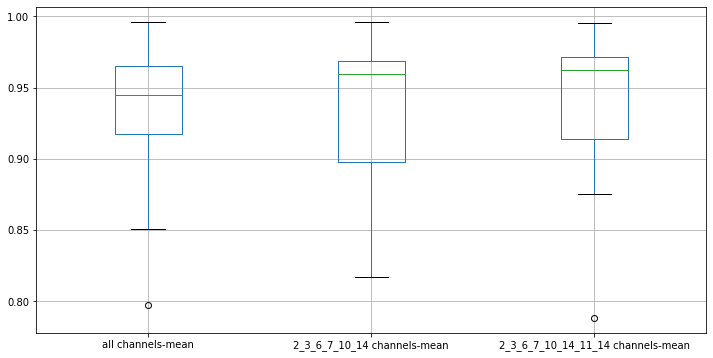

In [4]:
all_vs_some_df[only_means].boxplot(figsize=(12, 6))
all_vs_some_df[only_means].describe()